# Introduction

ブラジルの第3位の保険会社（Porto Seguro） が主催し、運転手の保険が開始される確率を予測するものです。
このノートブックは、PythonビジュアライゼーションライブラリPlot.lyを使っていくつかのインタラクティブなチャートと競合データの分析を提供し、他の人が取ったり複製したりできるいくつかの洞察と美しいプロットをもたらすことを目指します。 Plot.lyは、ソフトウェア企業が提供する主要製品の1つです。 [Plotly]は、グラフィカルで統計的な視覚化（チャートとダッシュボード）を提供するだけでなく、 Python、R、Matlab、Node.jsなどの豊富なプログラミング言語とツール群で使えます。
簡単な利便性のために、以下の表は、このノートブックのさまざまなPlotlyプロットへのリンクです：
* 横棒グラフ - ターゲット変数の分布を検査するために使用されます　
* 相関ヒートマッププロット - 異なるフィーチャ間の相関関係を見ます 　
* 散布図 - ランダムフォレストとグラデーションブーストモデルで生成されたフィーチャの大小を比較します。　
* 縦棒グラフ - 降順のリスト、さまざまな機能の重要性
* 3D散布図
       
       
このノートブックのテーマは以下のように簡単に要約できます：
**1・データ品質チェック** （＃品質） - すべての欠損値/ヌル値（-1の値）の可視化と評価
**2・フィーチャ検査とフィルタリング - 相関とフィーチャターゲット変数に対する相互情報プロット。バイナリ、カテゴリおよびその他の変数の検査。
**3・学習モデルによる特徴重要度ランキング　- ランダムフォレストとグラデーションブーストモデルを構築し、学習プロセスに基づいて機能をランク付けするのに役立ちます。


In [51]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

提供されたトレーニングデータを読み込みましょう:

In [33]:
train = pd.read_csv("./train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [34]:
# 何行あるか何カラムあるかチェックしてみましょう
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


<a id='quality'></a>
## データ品質チェック

**ヌル値または欠損値のチェック**

品質検査の一環として、次のようにトレーニングデータセットにヌル値があるかどうかを素早く見てみましょう。

In [35]:
# any() applied twice ： データセットに含まれる行と列の数を確認する
train.isnull().any().any()

False

* null値チェックはFalseを返しますが、データが[-1の値は観測から欠落していることを示します]（https：//）と記述されているため、このケースは閉じられているわけではありません。 www.kaggle.com/c/porto-seguro-safe-driver-prediction/data）。 したがって、ポルト・セグロは、データのすべてのヌル値を-1の値でブランケット置換しただけです。 データの欠損値がどこにあるのか調べてみましょう。


ここでは、どの列が値に-1を含んでいるかを見ることができます。たとえば、次のように、すべて-1のヌルを最初にブランケット置換することができます。

In [36]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

次に、データセットの欠損値を視覚化する上で便利なツールである「Missingno」パッケージのを使用することができます。

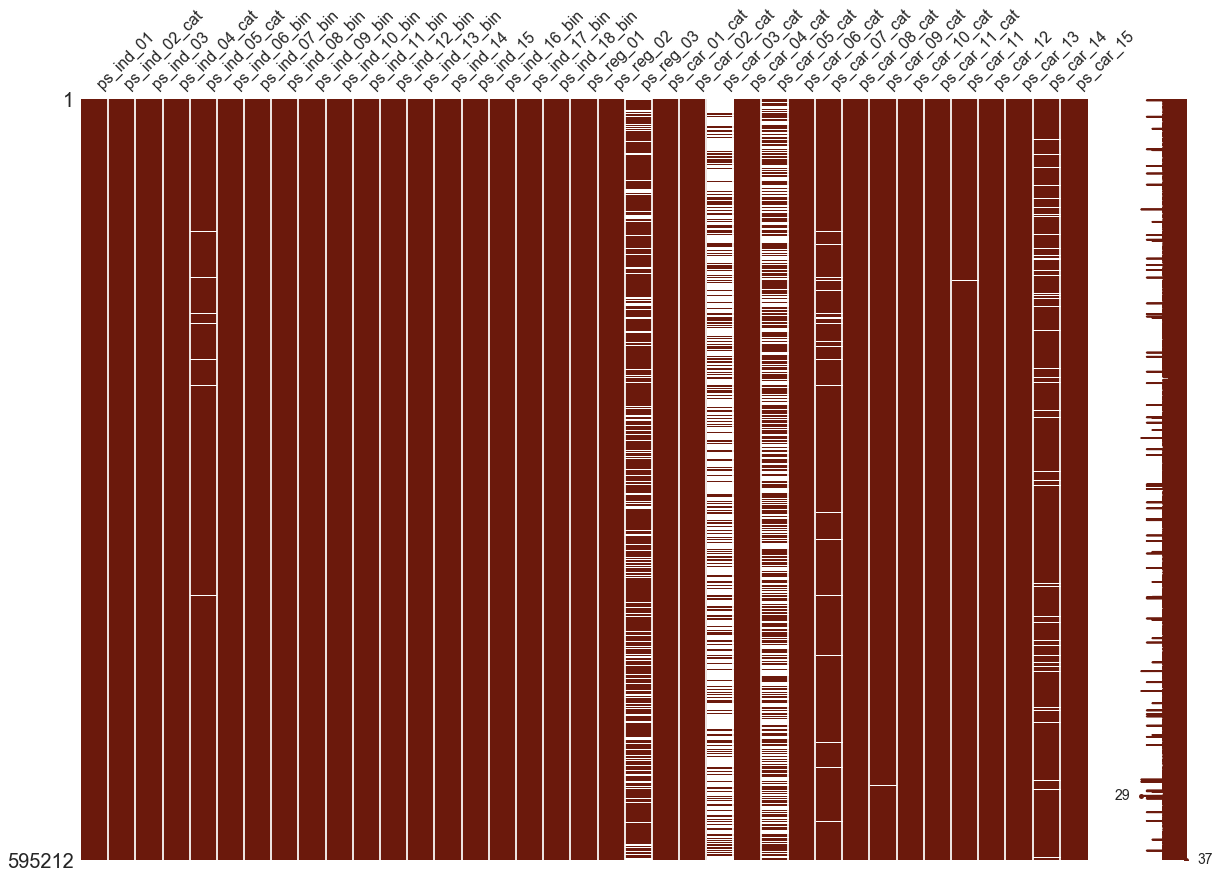

In [37]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:,2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))


欠損値は、視覚化すると明らかになります。

空白の白いバンド（欠落しているデータ）は、縦の濃い赤いバンド（重複していないデータ）に重なってデータの無効を反映します。

その特定の列に表示されます。この例では、59のトータルフィーチャのうち7つのフィーチャがあることがわかります（コメントセクションのJustin Nafeが本当に指摘しているように、実際にヌル値を含む合計13列の値が欠落しています）。これは、不足しているマトリックス・プロットが約40個の奇数のフィーチャーに1つのプロットにしか快適に収まらず、その後いくつかの列が除外され、残りの5つのヌル列が除外されているためです。すべてのヌルを視覚化するには、データフレームをスライスする方法を調整するだけでなく、figsize引数を変更してみてください。

私たちが見ることができる7つのヌル列については、以下のようにここにリストされています。

** ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14 **

欠損値の大部分は、_catで終わる列に現れています。

実際にps_reg_03、ps_car_03_cat、ps_car_05_catという列にさらに注意する必要があります。

白から暗のバンドの比率から明らかなように、これらの3つの列から値の大多数が欠落していることは非常に明白であり、したがって、ヌルの-1のブランケット置換は非常に良い戦略ではないかもしれません。


**変数検査**

データ上で通常行われるもう1つの標準チェックは、列が便宜的に「ターゲット」と題されたターゲット変数に関するものです。目標値は、クラス/ラベル/正解のモニカによっても与えられ、与えられた対応するデータ（私たちの場合はid列以外のすべての学習データ）と共に学習モデルで使用され、最良のマップこの学習された機能が新しい目に見えないデータでも一般化して予測できることを期待して、データをターゲットに送信します。

In [38]:
data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Distribution of target variable'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

Hmmn, 検査の結果は不均衡なので、心に留めておくべきというレベルかもしれません。

**データ型チェック**

このチェックは、トレーニングセットがどのような種類のデータ型で構成されているかを確認するために実行されます。

文字列または浮動小数点数は、提供されたデータのより良い概要を得るためにのみ使用されます。 

Pythonシーケンスで一意の型の数を取得する1つのトリックは、** Collections **モジュールを次のようにインポートするときにCounterメソッドを使用することです。

In [39]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

上記のように学習データセットを構成する合計59の列があり、このチェックからわかるように、フィーチャ/列は整数と浮動小数点の2つのデータ型のみで構成されています。
Porto Seguro（保険会社）は実際には、_bin、_cat、_regのような略語が末尾に付いたヘッダーをデータとして提供しています。_catはバイナリ機能を示し、_catはバイナリ機能を示しています。残りの部分は連続的または序数的な特徴のいずれかである。ここでは、浮動小数点数（たぶん連続フィーチャのみ）と整数データ型（バイナリ、カテゴリ、および序数フィーチャ）を見るだけでこれをさらに単純化します。

In [40]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

## 相関プロット

まず、フィーチャが次のフィーチャとどのように関係にあるかを素早く見て洞察を得ることを開始するために、相関プロットを生成してみましょう。 

ここでは、統計的視覚化パッケージを使用して、相関値のヒートマップをプロットします。 

Pandasのデータフレームには、Pearson相関を計算するcorr（）メソッドが組み込まれています。 
また、SNSの相関プロットの呼び出し方法も便利です。 

**浮動小数点機能の相関**

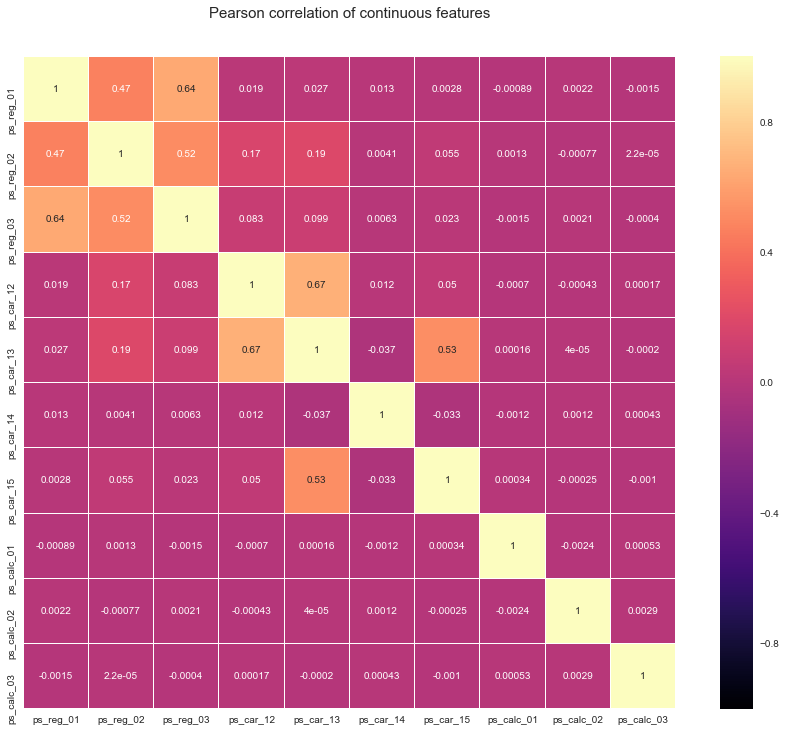

In [41]:
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

相関プロットから、大部分のフィーチャは互いにゼロまたは非相関を表示することがわかります。これは私たちのさらなる調査を後で保証することになる、非常に興味深い観察です。現時点では、正の線形相関を示す対のフィーチャが次のようにリストされています。

**(ps_reg_01, ps_reg_03)**

**(ps_reg_02, ps_reg_03)**

**(ps_car_12, ps_car_13)**

**(ps_car_13, ps_car_15)**

**整数フィーチャの相関**

ntergerデータ型の列については、Plotlyライブラリを使用して、相関値のヒートマップをインタラクティブに生成する方法を示します。以前のPlotlyプロットと同様に、単に "go.Heatmap"を呼び出すことでヒートマップオブジェクトを生成します。ここでは、3つの異なる軸に値を入力する必要があります。ここで、x軸とy軸は列名を取り込み、相関値はz軸で与えられます。 colorscale属性は、ヒートマップに表示されるさまざまなカラーパレットに対応するキーワードを取ります。この例では、私はGraysのカラースケールを使用しています（他のものにはPortlandとViridisが含まれます）。

In [42]:
#train_int = train_int.drop(["id", "target"], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
#zにtrain_intの相関係数　x,yにカラム
#colorsxcale = カラーのテーマ
#opacity = トレースの不透明度を設定します。
#reversescale　= Trueの場合、の場合、カラーマッピングを元に戻します。
#textをTrueにするとエラーが出ました。
data = [
    go.Heatmap(
        z= train_int.corr().values,
        x=train_int.columns.values,
        y=train_int.columns.values,
        colorscale='Viridis',
        reversescale = False,
        #text = True ,
        opacity = 1.0 )
]

#レイアウト
layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

同様に、相関プロットでは0の値のセルが非常に多く観測されていることから、直線的に相関しない膨大な数の列が存在することがわかります。特に、主成分分析（PCA）などの次元削減変換を実行しようとしている場合は、ある程度の相関が必要です。興味のある機能は次のとおりです。

***否定的に、相関フィーチャー*** : ps_ind_06_bin, ps_ind_07_bin,  ps_ind_08_bin,  ps_ind_09_bin


注目すべき興味深いところは、私たちの初期の無効解析では、ps_car_03_catとps_car_05_catに多くの欠損値またはヌル値が含まれていることが分かりました。したがって、これらの両方の特徴が、データの根底にある真理を実際に反映していないかもしれないにもかかわらず、この基準で互いに強い正の線形相関を示すことは驚くべきことではありません。


## 相互情報プロット

相互情報は、ターゲット変数とそれに対して計算される対応するフィーチャとの間の相互情報を検査することを可能にするもう1つの有用なツールである。分類問題では、Sklearnのmutual_info_classifメソッドを呼び出すことで、2つの確率変数間の依存関係を測定し、ゼロ（ランダム変数が互いに独立している）からより高い値（依存関係を示す）までの範囲で簡単に呼び出すことができます。これは、ターゲットからのどのくらいの情報がフィーチャー内に含まれるのかを私たちに知らせるのに役立ちます。


mutual_info_classif関数のsklearnの実装は、「k最近傍距離からのエントロピー推定に基づくノンパラメトリックな手法に依存している」と述べています。(http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif).

In [43]:
mf = mutual_info_classif(train_float.values,train.target.values,n_neighbors=3, random_state=17 )
print(mf)

[ 0.01402035  0.00431986  0.0055185   0.00778454  0.00157233  0.00197537
  0.01226     0.00553038  0.00545101  0.00562139]


## バイナリ機能検査


検査する可能性のあるデータの別の側面は、バイナリ値のみを含む列です。つまり、値が1または0の2つの値のどちらか一方しか取ることはありません。先に、これらのバイナリ値を含むすべての列を格納し、 これらのバイナリ値の垂直プロットバープロットは次のようになります。

In [44]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((train[col]==0).sum())
    one_list.append((train[col]==1).sum())

In [45]:
trace1 = go.Bar(
    x=bin_col,
    y=zero_list ,
    name='Zero count'
)
trace2 = go.Bar(
    x=bin_col,
    y=one_list,
    name='One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

ここでは、ps_ind_10_bin、ps_ind_11_bin、ps_ind_12_bin、ps_ind_13_binの4つの機能が存在することがわかります。ps_ind_10_binは完全にゼロによって支配されています。これは、ターゲットに対する他のクラスに関する多くの情報を含んでいないので、これらの機能がまったく有用であるかどうかという問題を招きます。

## カテゴリカルおよび順序チェック

最初に、接尾辞 "_cat"のようにカテゴリに分類される機能を見てみましょう。


## ランダムフォレストによる機能の重要性
ここではランダムフォレストモデルを実装し、ランダムフォレストクラシファイアとトレーニングデータを適合させ、モデルがトレーニングを終えた後の機能のランキングを見てみましょう。 これは、便利な機能のインポートを取得する際に多くのパラメータ調整を必要とせず、ターゲットの不均衡に対してかなり堅牢なアンサンブルモデル（Bootstrap集約下で適用された弱意思決定ツリー学習者のアンサンブル）を使用する迅速な方法です。 私たちはランダムフォレストを以下のように呼んでいます：

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150, max_depth=8, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
rf.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


**Plot.ly Scatter Plot**

ランダムフォレストをトレーニングした後、属性「feature_importances_」を呼び出して散布図にプロットすることで、フィーチャのインポートのリストを取得できます。
ここでは、Scatterコマンドで、前のPlotlyプロットと同様に、y軸とx軸を定義する必要があります。しかし、散布図に注意を払うのはマーカー属性です。 埋め込まれた散布点のサイズ、色、スケールを定義し、それによって制御するのはマーカー属性です。

In [47]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

さらに、重要度の高い順にランク付けされたすべてのフィーチャのソートされたリストを、次のような同じプロットの棒グラフを使用して最高から最低まで表示することもできます。

In [48]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

**決定木ビジュアル化**

他の興味深いトリックやテクニックの1つは、モデルによって作られた木の枝や意思決定を視覚化することです。 
簡単にするために、私は意思決定ツリー（max_depth = 3）で意思決定ブランチで3つのレベルをみています。


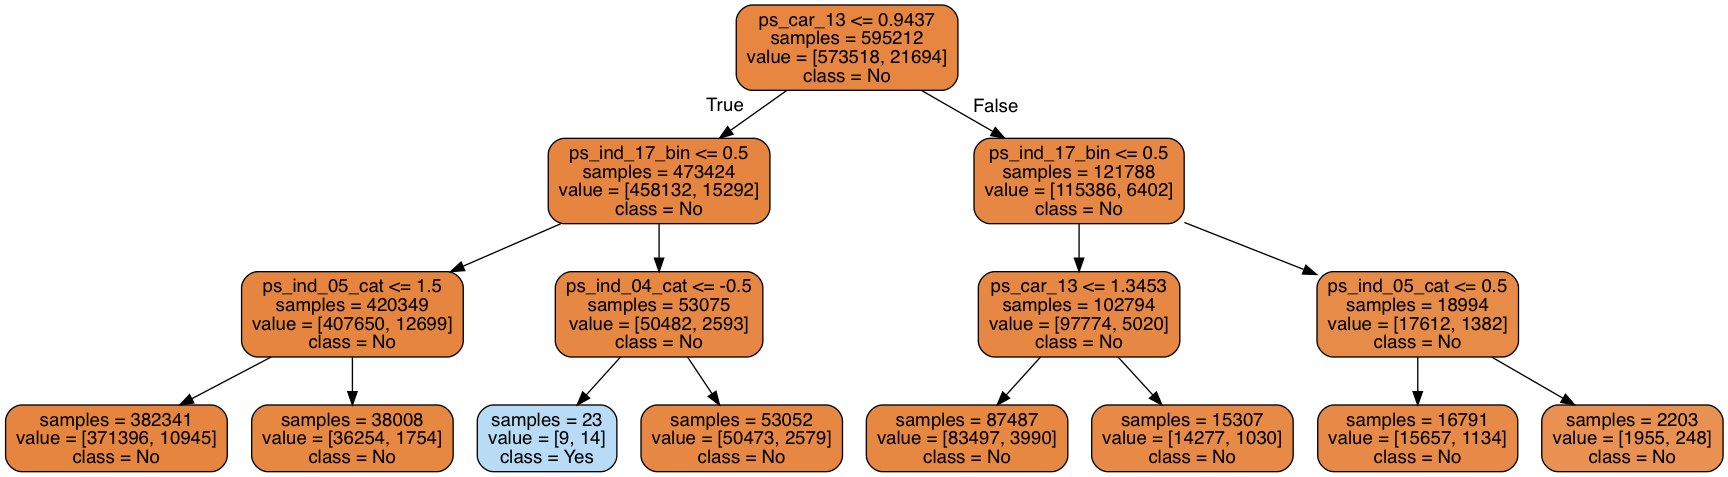

In [63]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)


## Gradient Boostingモデルによる機能の重要性

別の学習方法を試してみましょう。 今回は、Gradient Boostingクラシファイアを使用してトレーニングデータに合わせます。 Gradient Boostingは、各ステージで損失関数の傾き（Sklearnの実装ではデフォルト値である）に当てはまる、段階的な方法で進行します。

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'],axis=1), train.target)
features = train.drop(['id', 'target'],axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [64]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [54]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')

興味深いことに、ランダムフォレストとグラジエントブースト学習モデルの両方で、両モデルが選んだ最も重要な機能は、列： ps_car_13 です。
この特定の機能は詳細な調査を必要とするため、深く掘り下げて検討してください。


# 結論


我々は、Porto Seguroデータセットのかなりの検査を行いました。ヌル値とデータ品質を検査し、フィーチャ間の線形相関を調べ、フィーチャ分布のいくつかを検査し、いくつかの学習モデル（ランダムフォレストとグラジエントブースト分類器）を実装しました。モデルが重要であると考える特徴を知ることができました。

# *続く、、、